In [1]:
import hklearn 
from hklearn import Stack, ModelSet
import joblib
import matplotlib.pyplot as plt
import numpy as np
from hklearn.transforms import LogRatioScaler
import hylite
import pandas as pd
from hycore import loadShed
from sklearn.metrics import r2_score
import os
from matplotlib.colorbar import Colorbar
from matplotlib.transforms import Bbox
import dill
from sklearn.base import clone

In [2]:
#setup figure styles
import matplotlib as mpl
plt.style.use(['default'])
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.titleweight'] = 'normal'
mpl.rcParams['savefig.dpi'] = 350
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2
dipcmap = plt.get_cmap("RdYlGn_r")

### Load stack

Load the Stack object containing our data, and the associated dictionary of spectral indices and sample properties.

In [3]:
S = Stack.load('volcanoes.stack')
with open('indices.dill', 'rb') as f:
    indices = dill.load(f)

### Load modelset

In [4]:
# load univariate models
M1 = ModelSet.load("uni_models.set")
M1.bind(S) # not necessary, but why not

In [5]:
for n,m in M1.models.items():
    out = m.fit_output
    # print the optimum hyperparameters
    print("\n5-fold CV scores: avg (%.2f)"%np.mean(out['kfold_score_all']),end='')
    for tn,r in zip( S.target_names, out['kfold_score_all'] ):
        print("  %s (%.2f) "%(tn,r), end='')
    print(" [ %s ]"%n) # print model name


5-fold CV scores: avg (0.31)  density (0.39)   porosity (0.33)   UCS2_MPa (0.21)   E_GPa (0.30)  [ uni_lasso_pca ]

5-fold CV scores: avg (0.38)  density (0.51)   porosity (0.48)   UCS2_MPa (0.18)   E_GPa (0.36)  [ uni_PLSR_pca ]

5-fold CV scores: avg (0.69)  density (0.78)   porosity (0.72)   UCS2_MPa (0.66)   E_GPa (0.58)  [ uniMLP_512x4_pca ]

5-fold CV scores: avg (0.71)  density (0.80)   porosity (0.79)   UCS2_MPa (0.62)   E_GPa (0.62)  [ uniMLP_512x6_pca ]

5-fold CV scores: avg (0.72)  density (0.84)   porosity (0.78)   UCS2_MPa (0.62)   E_GPa (0.63)  [ uniMLP_512x8_pca ]

5-fold CV scores: avg (0.72)  density (0.82)   porosity (0.78)   UCS2_MPa (0.63)   E_GPa (0.65)  [ uniMLP_512x10_pca ]

5-fold CV scores: avg (0.71)  density (0.80)   porosity (0.74)   UCS2_MPa (0.63)   E_GPa (0.67)  [ uniMLP_512x12_pca ]

5-fold CV scores: avg (0.72)  density (0.83)   porosity (0.78)   UCS2_MPa (0.62)   E_GPa (0.64)  [ uniMLP_512x16_pca ]

5-fold CV scores: avg (0.69)  density (0.79)   poro

In [ ]:
# load multivariate models
M2 = ModelSet.load("multi_models.set")
M2.bind(S) # not necessary, but why not

In [ ]:
for n,m in M2.models.items():
    out = m.fit_output
    # print the optimum hyperparameters
    print("\n5-fold CV scores: avg (%.2f)"%np.mean(out['kfold_score_all']),end='')
    for tn,r in zip( S.target_names, out['kfold_score_all'] ):
        print("  %s (%.2f) "%(tn,r), end='')
    print(" [ %s ]"%n) # print model name

### Generate combined prediction

Construct an EnsembleModel that combines the predictions of all our model set.

In [ ]:
to_keep = ['uni_svr_pca', 
           'uniMLP_512x12_pca', 
           'uniMLP_1024x12_pca', 
           'uniMLP_1024x16_pca',
           'uniMLP_2048x8_pca',
           'multiMLP_2048x6_pca',
           'multiMLP_2048x8_pca',
           'multiMLP_2048x10_pca',
           'multiMLP_2048x12_pca' ]

for M in [M1, M2]:
    to_del = [k for k in M.models.keys() if k not in to_keep]
    for k in to_del:
        del M.models[k]

In [10]:
# merge model sets together
M.models = {**M1.models, **M2.models}

In [10]:
# save our "best" model set
M.save('best_models.set')

In [4]:
if True:
    M = ModelSet.load("best_models.set")
    M.bind(S)

### Cross validation

Now we combine the (5-fold cross validation) outputs of these models to get an ensemble estimate that includes a measure of uncertainty (well, inconsistency).

In [5]:
# combine model estimates to get the ensemble's 5-fold CV estimates
models = []
ycv_ = []
for m in M.models.values():
    models.append(m.models) # store individual fold models
    ycv_.append(m.ycv_)
    
y_pred = np.mean(ycv_, axis=0 )
y_std = np.std( ycv_, axis=0 )

In [6]:
# compute r2 scores
from sklearn.metrics import r2_score
r2 = r2_score( S.y(), y_pred, multioutput='raw_values')

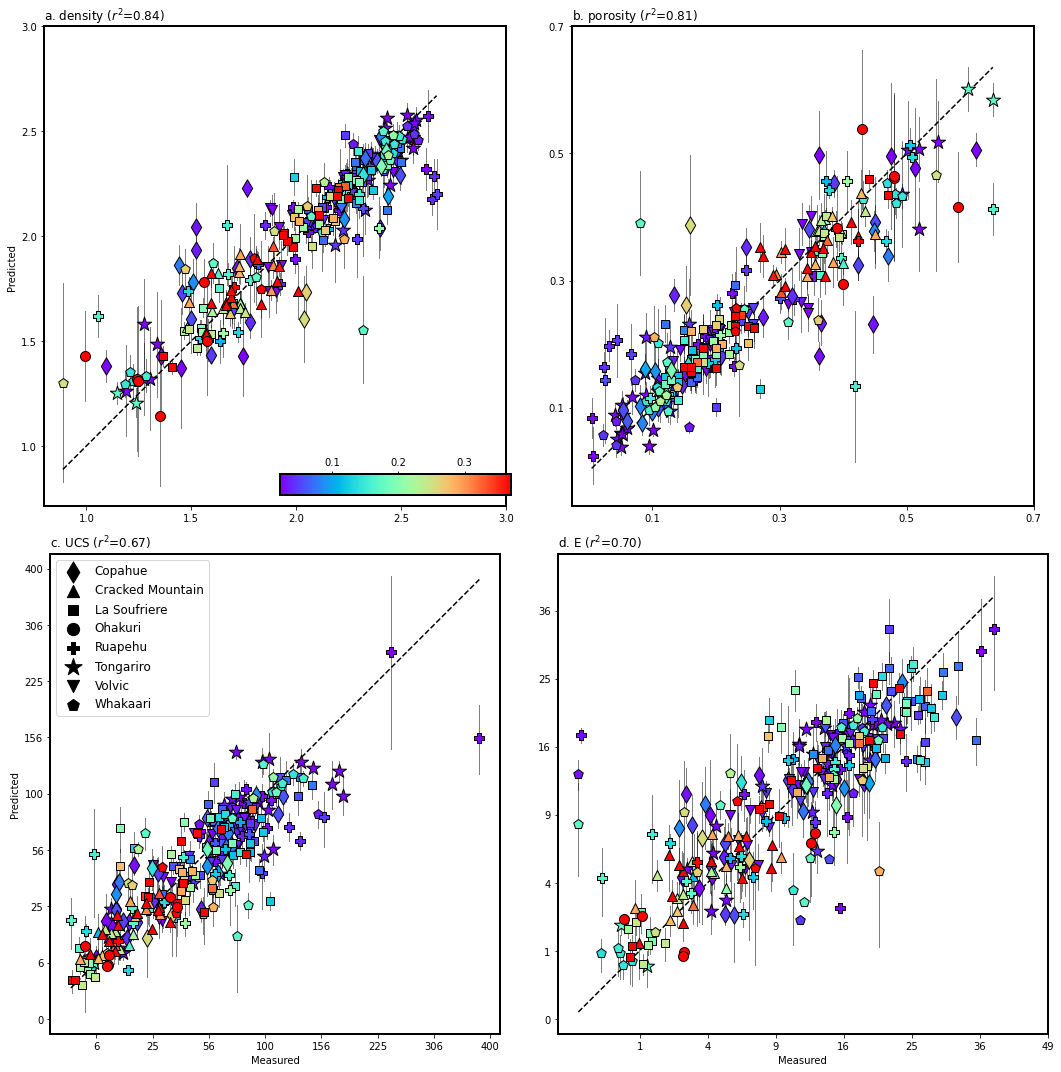

In [10]:
titles = ['a. density ($r^2$=%.2f)'%r2[0], 'b. porosity ($r^2$=%.2f)'%r2[1], 'c. UCS ($r^2$=%.2f)'%r2[2], 'd. E ($r^2$=%.2f)'%r2[3]]


# define symbology for each volcano
s = {'Copahue':'d','Cracked Mountain':'^','La Soufriere':'s','Ruapehu':'P',
     'Ohakuri':'o','Tongariro':'*','Volvic':'v','Whakaari':'p'}
sz = {'*':2.2,'d':1.5,'p':1.,'+':2, 's':0.8} # adjust default marker size so they are more perceptually uniform

ids = indices['sample_id'][ S.valid[:,0] ] # sample IDS
volcs = indices['volcanoes'][ S.valid[:,0] ] # volcano name

# sort out colours
cvar = indices['hydration'][ S.valid[:,0] ]
#cvar = indices['fmi'][ S.valid[:,0] ]
#cvar = S.y()[:,1] # porosity
vmin,vmax = np.percentile(cvar,(10,90))

# do plot!
fig,ax = plt.subplots(2,2, figsize=(15,15))


# labels etc.
ax[1,0].set_xlabel("Measured")
ax[1,1].set_xlabel("Measured")
ax[0,0].set_ylabel("Predicted")
ax[1,0].set_ylabel("Predicted")

# add titles
for i,a in enumerate(ax.ravel()):
    a.set_title(titles[i],loc='left')
    a.set_aspect('equal')
    a.minorticks_off()
    
fig.tight_layout()

# plot
for i,a in enumerate(ax.ravel()):
    for v in np.unique(volcs):
        if v not in s: # skip these as we don't have complete mech data
            continue
        
        # get volcano symbol
        _s = s[v]
        _sz = 100*sz.get(_s,1)
    
        # get mask of the points that belong to this volcano
        mask = volcs == v

        # plot
        for j in range(np.sum(mask)):
            _x = M.stack.y()[mask,i][j] # true
            _y = y_pred[mask,i][j] # predicted
            _e0 = _y - 2*y_std[mask,i][j] # lower error (2 sigma)
            _e1 = _y + 2*y_std[mask,i][j] # upper error (2 sigma)
            if i >= 2:
                _x = np.sqrt(_x)
                _y = np.sqrt(_y)
                _e0 = np.sqrt(_e0)
                _e1 = np.sqrt(_e1)
            cm = a.scatter( _x, _y, 
                        c=cvar[mask][j], alpha=1., vmin=vmin, vmax=vmax, cmap='rainbow',
                        edgecolors='k', marker=_s, s=_sz, zorder=cvar[mask][j] ) # bring high values to front
            a.plot( [_x,_x], [_e0, _e1], c='k',zorder=0, lw=1, alpha=0.5 ) # plot error bar
            # a.text(_x, _y, ids[mask][j], fontsize=10, zorder=100) ## for identifying specific samples
    # plot 1:1 line
    if i >= 2:
        _r = np.array([np.min( [np.sqrt(y_pred[:,i]), np.sqrt(M.stack.y()[:,i] )]), 
              np.max( [np.sqrt(y_pred[:,i]), np.sqrt(M.stack.y()[:,i] )])])
        
        a.plot(_r,_r,color='k',ls='--',zorder=0) # plot 1:1 line
        a.set_yticklabels(["%d"%(y**2) for y in a.get_yticks()])
        a.set_xticks([t for t in a.get_yticks() if t > 0])
        a.set_xticklabels(["%d"%(x**2) for x in a.get_xticks()])

    else:
        _r = [np.min( [y_pred[:,i], M.stack.y()[:,i] ]), np.max( [y_pred[:,i], M.stack.y()[:,i] ])]
        a.plot(_r,_r,color='k',ls='--',zorder=0)
        if i == 0:
            a.set_xticks([t for t in a.get_yticks()[::2] if t >= 1])
        else:
            a.set_xticks([t for t in a.get_yticks()[::2] if t >= 0.1])
        a.set_yticks(a.get_xticks())
        
# Create colorbar in the top-right corner of each axis
ax_bbox = ax[0,0].get_position()
w = 0.5
cbar_width = w * ax_bbox.width  # Reduce width of the colorbar
cbar_height = 0.02  # Height of the colorbar
#cbar_x = ax_bbox.width  - 0.06  # Offset to the lower left
#cbar_y = ax_bbox.y1 - ax_bbox.height + 0.05  # Slightly above the plot
cbar_x = ax_bbox.width - 0.36*ax_bbox.width   # Offset to the lower left
cbar_y = ax_bbox.y1 - ax_bbox.height + 0.01  # Slightly above the plot

# Create a new axis for the colorbar
cbar_ax = fig.add_axes([cbar_x, cbar_y, cbar_width, cbar_height])
cb = Colorbar(cbar_ax, cm, orientation="horizontal")

cb.ax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")
cb.ax.set_xticks([0.1, 0.2, 0.3])
cb.ax.set_xticklabels(["0.1", "0.2", "0.3"])


# distribute legend across top-left of each plot
if False:
    for i,volcs in enumerate([ ['Copahue','Cracked Mountain'],
                               ['La Soufriere','Ruapehu'],
                               ['Ohakuri','Tongariro',],
                               ['Volvic','Whakaari']]):
        for v in volcs:
            cm = ax.ravel()[i].scatter(np.nan, np.nan, s=150*sz.get( s.get(v,'.'), 1),
                        c='k', alpha=1.0, edgecolors='k', marker=s.get(v,'.'), label=v )
        ax.ravel()[i].legend(loc='upper left', prop={'size': 16})
else:
    for v in np.unique(volcs):
        cm = ax[1,0].scatter(np.nan, np.nan, s=150*sz.get( s.get(v,'.'), 1),
                            c='k', alpha=1.0, edgecolors='k', marker=s.get(v,'.'), label=v )
    ax[1,0].legend(loc='upper left', prop={'size': 12}, ncol=1 )
    
fig.savefig("./figures/biplots.png", dpi=300)
fig.savefig("./figures/biplots.svg", dpi=300)
fig.show()

#### Ensemble estimator

Finally, to help make predictions we combine our various models into a single ensemble estimator. This can then be used to e.g., do inference on new images, or compute SHAP values to explore which spectral features are informative to the model set.

In [11]:
from hklearn.estimators.ensemble import EnsembleEstimator

In [12]:
estimators = []
for k,e in M.models.items():
    # break ensembles into their individual models 
    # (so we get better variance estimates)
    estimators += e.models 

# build a single ensemble estimator
est = EnsembleEstimator( estimators, combination_method='average', n_jobs=len(estimators) )

# add to a ModelSet to handle preprocessing and transforms
Me = ModelSet().bind(S)
est.xtransform = True # transform input spectra before passing to model?
est.features_in = False # input to model is output from the feature models? (i.e. ModelSet.F())
Me.models['ensemble'] = est # store
Me.save("ensemble.set") # and save :-) 